# <center> **TA136 - Taller de Procesamiento de Señales**
## <center> **Trabajo Práctico 4: Análisis de Discriminante y Vecinos más cercanos**

---
---

### <center> Introducción

&ensp; En el presente trabajo práctico se aborda la clasificación de especies del género Iris a partir de características del sépalo, utilizando distintos modelos supervisados. El enfoque se basa en aplicar y comparar métodos estadísticos y algorítmicos de clasificación, como el Análisis Discriminante Lineal (*LDA*), el Análisis Discriminante Cuadrático (*QDA*) y el algoritmo k-Vecinos más Cercanos (*k-NN*).

&ensp; El estudio se realiza a partir del dataset Iris provisto por la biblioteca `sklearn`, considerando únicamente las variables asociadas al largo y ancho del sépalo. Se implementan los modelos desde cero, permitiendo así comprender en profundidad su funcionamiento interno y su comportamiento frente a los datos. Además, se generan muestras sintéticas a partir de los modelos *LDA* y *QDA*.

&ensp; Además, se compara el comportamiento de los modelos y se analiza su desempeño mediante los gráficos de las regiones de decisión y las *accuracy* de testeo como de entrenamiento. La implementación se llevó a cabo íntegramente en $\texttt{Python}$, utilizando bibliotecas como `Sklearn`, `Numpy`, `Matplotlib` y `Pandas`.

---
---

### <center> Desarrollo

Iris es un género de plantas rizomatosas de la familia *Iridaceae*. Dentro de las plantas de Iris existen muchas especies distintas, entre ellas *setosa*, *versicolor* y *virgínica*. Se desea desarrollar un clasificador de dichas plantas a partir del tamañoo de su sépalo.

---

#### (A). *Exploración de datos:*

**1. Cargar la base de datos utilizando $\texttt{datasets.load\_iris}$ (`sklearn`). Utilizar solamente las dimensiones del sépalo. Graficar las muestras en un scatter, representando las diferentes especies de Iris con colores distintos.**

&ensp; En un principio, se carga el conjunto de datos Iris utilizando la función recomendada por la cátedra. Se especifica el parámetro `as_frame` como `True` para obtener los datos en un *dataFrame* de la librería `pandas`. A partir de esto, se eliminan las columnas relacionadas con los pétalos, conservando únicamente las columnas del sépalo (largo y ancho), que son las variables relevantes para este trabajo.

&ensp; Luego, se agrega una columna `clase` con los valores numéricos de las clases (0, 1, 2) y una columna `especie` donde se asigna el nombre correspondiente a cada clase, a fin de visualizar qué especie se corresponde con cada número. Una vez realizado esto, se imprimen $10$ muestras aleatorias de la tabla, con el objetivo de mostrar los datos y analizar que se hayan cargado correctamente.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

In [3]:
dataset = sk.datasets.load_iris(as_frame = True)

df = dataset['data'].drop(columns = ['petal length (cm)', 'petal width (cm)'])
df['clase'] = dataset['target']
df['especie'] = df['clase'].apply(lambda x: dataset['target_names'][x])

display(df.sample(10))

,sepal length (cm),sepal width (cm),clase,especie
135,7.7,3.0,2,virginica
66,5.6,3.0,1,versicolor
124,6.7,3.3,2,virginica
121,5.6,2.8,2,virginica
39,5.1,3.4,0,setosa
141,6.9,3.1,2,virginica
131,7.9,3.8,2,virginica
78,6.0,2.9,1,versicolor
96,5.7,2.9,1,versicolor
61,5.9,3.0,1,versicolor


&ensp; En base al *dataframe* creado anteriormente, se separan en distintos *dataframes* según la clase que tengan y se verifica que la dimensión sea de $50 \times 4$, ya que, es lo que está específicado por la función $\texttt{load\_iris}$.

In [4]:
data_0 = df[df['clase'] == 0]
data_1 = df[df['clase'] == 1]
data_2 = df[df['clase'] == 2]

display(data_0.shape)
display(data_1.shape)
display(data_2.shape)

(50, 4)

(50, 4)

(50, 4)

&ensp; Se define una función auxiliar que permite graficar un *scatter plot* de las dimensiones del sépalo para las tres especies de Iris. La función recibe como entrada un *dataframe* por clase, junto con un título y una paleta de colores. Esto permite reutilizar el mismo código para generar múltiples gráficos a lo largo del trabajo, mejorando la legibilidad y evitando repeticiones.


In [5]:
def scatter_dataset(datos_0, datos_1, datos_2, title, colors):
    plt.scatter(datos_0['sepal length (cm)'], datos_0['sepal width (cm)'], marker = 'x', c = colors[0], label = 'Setosa', zorder = 2)
    plt.scatter(datos_1['sepal length (cm)'], datos_1['sepal width (cm)'], marker = 'o', c = colors[1], edgecolors = 'k', label = 'Versicolor', zorder = 2)
    plt.scatter(datos_2['sepal length (cm)'], datos_2['sepal width (cm)'], marker = '+', c = colors[2], label = 'Virginica', zorder = 2)
    plt.xlabel('Sepal Length [cm]')
    plt.ylabel('Sepal Width [cm]')
    plt.title(title)
    plt.legend()
    plt.xlim(3.5, 8)
    plt.ylim(1.5, 5)

&ensp; De esta manera, se definen los colores a utilizar y se realiza el *scatter plot* solicitado en las consignas, mostrando la dispersión de los datos en función de cada especie y sus respectivas mediciones del sépalo.

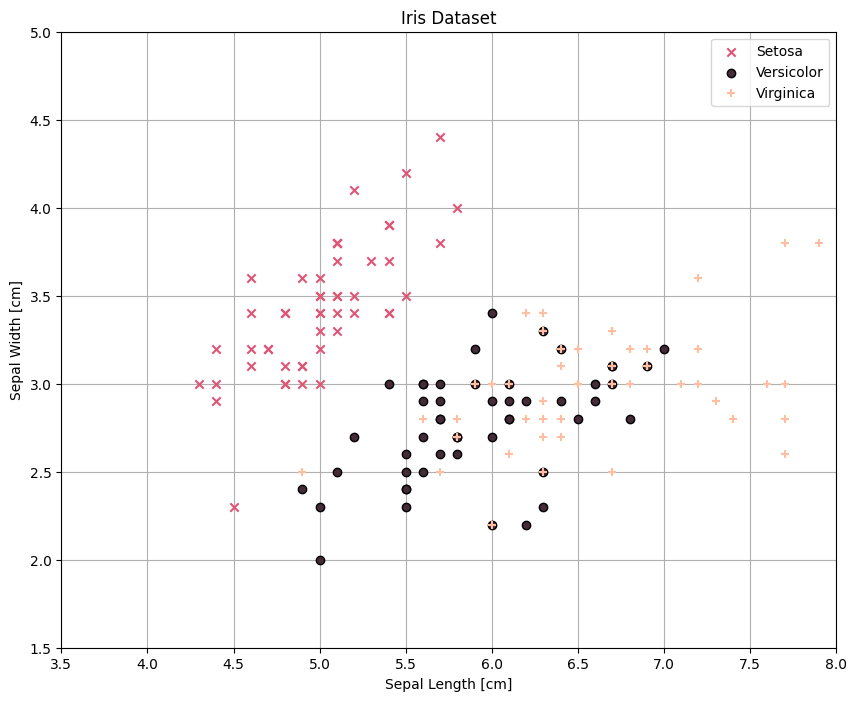

In [6]:
colores = ['#e05576', '#452a37', '#ffbda1']

plt.figure(figsize = (10, 8))
scatter_dataset(data_0, data_1, data_2, 'Iris Dataset', colores)
plt.grid(zorder = 1)
plt.show()

**2. Utilice el comando $\texttt{train\_test\_split}$ (`sklearn`) para definir los conjuntos de entrenamiento y testeo con las proporciones $70 ~ \%$ y $30 ~ \%$.**

&ensp; A partir de la función previamente utilizada en otros trabajos de la materia, se procede a separar los datos obtenidos en dos subconjuntos: uno para entrenar a los modelos desarrollados a lo largo del trabajo y otro para testearlos. Esto permite medir la efectividad del algoritmo de manera objetiva, al utilizar datos independientes para la prueba.

In [7]:
X_data = np.array(df[['sepal length (cm)', 'sepal width (cm)']])
Y_data = np.array(df['clase'])

X_train, X_test , Y_train, Y_test = sk.model_selection.train_test_split(X_data, Y_data, test_size = 0.3)

---

#### (B) *Clasificación LDA:*

**1. Implementar un algoritmo de LDA a partir de las dimensiones del sépalo para clasificar las plantas de Iris. El código debe estar estructurado de la siguiente manera:**

```python
    class LDA:
        # Inicializar atributos y declarar hiperparámetros
        def __init__(self,...

        # Etapa de entrenamiento
        def fit(self, X, y):

        # Etapa de testeo soft
        def predict_proba(self, X):

        # Etapa de testeo hard
        def predict(self, X):
```

&ensp; Antes de describir lo realizado, se realiza un paneo teórico de lo desarrollado. Para esto, se debe tener en cuenta que el modelo *LDA* sigue las siguientes hipotésis donde $Y$ es una categórica de probabilidades $c_k$ e $X | Y = k$ sigue una distribución gaussiana con media dependiente de la clase $\mu_k$ y matriz de covarianza general para todas las clases $\Sigma$.

$$ Y \sim Cat \left( \{ c_1, \dots , c_k \} \right), ~~~~ X | Y = k \sim N \left( \mu_k , ~ \Sigma \right).$$

De esta manera, se puede escribir a partir del Teorema de Bayes y haciendo un poco de álgebra:

$$p(Y | X) = \frac{p(X | Y) \cdot p_Y(y)}{p_X(x)} = \frac{p(X | Y) \cdot p_Y(y)}{\sum_{k \in \tilde{Y}} p_Y(k) \cdot p(X | Y = k)} = \frac{C_y ~ \exp \left(  - \frac{1}{2} (X - \mu_y)^T ~ \Sigma^{-1} ~ (X  - \mu_y) \right)}{\sum_{k \in \tilde{Y}} C_k ~ \exp \left(  - \frac{1}{2} (X - \mu_k)^T ~ \Sigma^{-1} ~ (X  - \mu_k) \right)}.$$

Entonces, desarrollando los exponentes se puede ver claramente que el término cuadrático, dado por:

$$ -\frac{1}{2} X^T ~ \Sigma^{-1} ~ X$$

Es igual en ambos exponentes y por lo tanto se anula, obteniendo así exponentes de la forma:

$$ \underbrace{\mu_k^T \Sigma^{-1}}_{w} ~ X - \underbrace{\frac{1}{2} ~ \mu_k^T \Sigma^{-1} \mu_k + \log(c_k) }_{b} $$

&ensp; Volviendo al código, con el objetivo de clasificar las plantas del Iris, se implementa una clase denominada `Discriminant_Analysis`. Cabe destacar que se desarrolla una única clase entre el *LDA* y el *QDA*, dada la similitud entre algoritmos. A continuación, se describen los métodos principales de la clase:

- `__init__:` Inicializa la clase, estableciendo el modelo a utilizar (*LDA* o *QDA*) y declarando los atributos necesarios para almacenar los parámetros del modelo, tales como las medias, las matrices de covarianza, los coeficientes *w* y el término *b*.

- `fit:` Ajusta el modelo a los datos de entrenamiento. Para ello, realiza los siguientes pasos:
    1. Calcula las probabilidades de cada clase y las almacena en `c_y`.

    2. Calcula la media y la matriz de covarianza de cada clase, y las guarda en `mean` y `covs`, respectivamente.

    3. Calcula la matriz de covarianza general en `cov`.

    4. Si el modelo es *LDA*, calcula los coeficientes `w` y `b` utilizando las medias de las clases, las covarianzas y las probabilidades a priori de las clases.

    5. Si el modelo es *QDA*, calcula el término logarítmico para cada clase guardandolo en `b`. No se calcula `w`, ya que, la clasificación se realiza usando la forma cuadrática, explicada más adelante.

- `predict_proba:` Devuelve las probabilidades de clase para cada fila de $X$. Para *LDA*, las probabilidades se calculan a partir de la fórmula dispuesta anteriormente, mientras que, para el *QDA* se añade el término cuadrático que se verá más adelante.

- `predict:` Utiliza las probabilidades calculadas por `predict_proba` y asigna a cada fila de $X$ la clase que le corresponde con la probabilidad más alta.


In [ ]:
class Discriminant_Analysis:

    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, model = None):
        if model not in ['LDA', 'QDA']:
            raise ValueError("El modelo debe ser 'LDA' o 'QDA'")

        self.model = model
        self.n_clases = None
        self.c_y = None
        self.mean = None
        self.covs = None
        self.covs_inv = None
        self.cov = None
        self.w = None
        self.b = None

    # Etapa de entrenamiento
    def fit(self, X, y):
        # Cantidad de clases y su frecuencia
        clases, contador_clases = np.unique(y, return_counts = True)
        self.n_clases = len(clases)

        # Arreglos para guardar los resultados
        self.c_y = np.zeros(self.n_clases)
        self.mean = np.zeros((self.n_clases, X.shape[1]))
        self.covs = np.zeros((self.n_clases, X.shape[1], X.shape[1]))
        self.covs_inv = np.zeros((self.n_clases, X.shape[1], X.shape[1]))
        self.cov = np.zeros((X.shape[1], X.shape[1]))
        self.w = np.zeros((self.n_clases, X.shape[1]))
        self.b = np.zeros(self.n_clases)

        # Parámetros de cada clase
        for i in range(self.n_clases):
            self.c_y[i] = contador_clases[i] / len(y)
            self.mean[i] = np.mean(X[y == i], axis = 0)
            self.covs[i] = (X[y == i] - self.mean[i]).T @ (X[y == i] - self.mean[i]) / (contador_clases[i] - 1)
            self.covs_inv[i] = np.linalg.inv(self.covs[i])
            self.cov += 1 / (len(y) - self.n_clases) * self.covs[i] * (contador_clases[i] - 1)

        cov_inv = np.linalg.inv(self.cov)

        # w y b para LDA; logaritmos para QDA
        if self.model == 'LDA':
            for i in range(self.n_clases):
                self.w[i] = cov_inv @ self.mean[i]
                self.b[i] = - 0.5 * self.mean[i].T @ cov_inv @ self.mean[i] + np.log(self.c_y[i])
        if self.model == 'QDA':
            for i in range(self.n_clases):
                self.b[i] = np.log(self.c_y[i]) - np.log(np.linalg.det(self.covs[i])) / 2

    # Etapa de testeo soft
    def predict_proba(self, X):
        if self.model == 'LDA':
            probs = X @ self.w.T + self.b
        if self.model == 'QDA':
            quadratic_term = np.zeros((X.shape[0], self.n_clases))
            for i in range(self.n_clases):
                diference = X - self.mean[i]
                quadratic_term[:, i] = - 0.5 * np.einsum('ni, ij, nj->n', diference, self.covs_inv[i], diference)
            probs = quadratic_term + self.b

        return np.exp(probs) / np.sum(np.exp(probs), axis = 1, keepdims = True)

    # Etapa de testeo hard
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis = 1)

**2. Superponer al scatter las medias y las covarianzas de cada gaussiana (una curva de nivel) del modelo de LDA.**

**3. Superponer al scatter las fronteras de decisión.**

&ensp; Para llevar a cabo este inciso, primero se inicializa y se entrena el modelo como se ve a continuación.

In [9]:
LDA_model = Discriminant_Analysis(model = 'LDA')
LDA_model.fit(X_train, Y_train)

&ensp; De esta manera, para visualizar el comportamiento del modelo *LDA*, se genera una grilla de puntos sobre el plano definido por las dos variables de entrada con la función $\texttt{np.meshgrid}$. A partir de esto, se evalúa la densidad de probabilidad de cada clase utilizando $\texttt{multivariate\_normal}$, que modela la distribución de los datos según la media de cada clase y la matriz de covarianza común del modelo. Las curvas de nivel son trazadas con $\texttt{plt.contour}$ y muestran dónde se concentra más la probabilidad de pertenecer a cada clase.

&ensp; Luego, se usa el método `predict` sobre todos los puntos de la grilla para estimar a qué clase pertenecería cada uno. Estas predicciones se representan con $\texttt{plt.contourf}$, generando regiones correspondientes a las distintas clases. Asimismo, se visualizan las fronteras de decisión del modelo. Por último, se grafica el conjunto de datos original con la función explicada anteriormente, permitiendo comparar los datos reales con las clasificaciones del modelo.

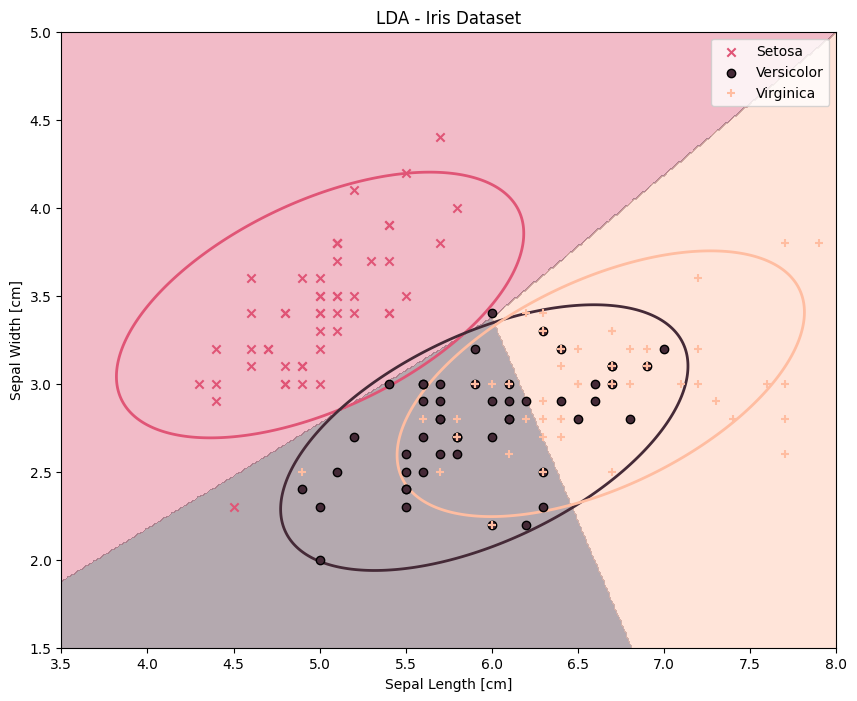

In [10]:
import scipy as sp

x = np.linspace(0, 10, 1000)
y = np.linspace(0, 10, 1000)
XX, YY = np.meshgrid(x, y)
grid = np.column_stack((XX.ravel(), YY.ravel()))

plt.figure(figsize = (10, 8))
for i in range(LDA_model.n_clases):
    gaussian = sp.stats.multivariate_normal(mean = LDA_model.mean[i], cov = LDA_model.cov)
    pdf_gaussian = gaussian.pdf(grid).reshape(XX.shape)
    plt.contour(XX, YY, pdf_gaussian, levels = [0.08], colors = colores[i], linewidths = 2)

Z = LDA_model.predict(grid).reshape(XX.shape)
plt.contourf(XX, YY, Z, levels = [-0.5, 0.5, 1.5, 2.5], colors = colores, alpha = 0.4, linestyles = 'solid')

scatter_dataset(data_0, data_1, data_2, 'LDA - Iris Dataset', colores)
plt.show()

**4. Reportar el accuracy de testeo.**

&ensp; Se implementa la función $\texttt{accuracy}$, que permite calcular la precisión que tiene el modelo comparando la predicción con el valor real. Además, se generaliza el modelo que se le puede pasar para poder reutilizarla en puntos posteriores del trabajo.

In [11]:
def accuracy(X, Y, model):
    Y_pred = model.predict(X)
    return np.sum(Y == Y_pred) / len(Y)

&ensp; En base a esta función, se obtienen los siguientes resultados.

In [12]:
accuracy_testeo_LDA = accuracy(X_test, Y_test, LDA_model)
display(f'Accuracy de Testeo modelo LDA: {accuracy_testeo_LDA:.2f}')

accuracy_train_LDA = accuracy(X_train, Y_train, LDA_model)
display(f'Accuracy de Entrenamiento modelo LDA: {accuracy_train_LDA:.2f}')

'Accuracy de Testeo modelo LDA: 0.80'

'Accuracy de Entrenamiento modelo LDA: 0.83'

---

#### (C) *Síntesis:*

**Utilizando el modelo LDA, generar 30 muestras sintéticas y graficarlas junto a las fronteras. Representar las diferentes especies de Iris con colores distintos.**

&ensp; A fin de generar las muestras sintéticas, se utiliza la función $\texttt{random.choice}$ para asignar clases a las muestras de acuerdo a las probabilidades estimadas por el modelo. Después, con $\texttt{random.multivariate\_normal}$, se generan vectores de características a partir de una distribución normal multivariada, utilizando las medias de cada clase y la covarianza general.

&ensp; Las muestras generadas se dividen en tres *dataframes* según su clase, lo que permite graficarlas con la función auxiliar $\texttt{scatter\_dataset}$. Nuevamente se utilizan las funciones mencionadas en el inciso anterior para generar las regiones de decisión y las curvas de nivel de cada clase. Esto permite observar cómo el modelo LDA separa espacialmente las clases y cómo se distribuyen las muestras generadas.


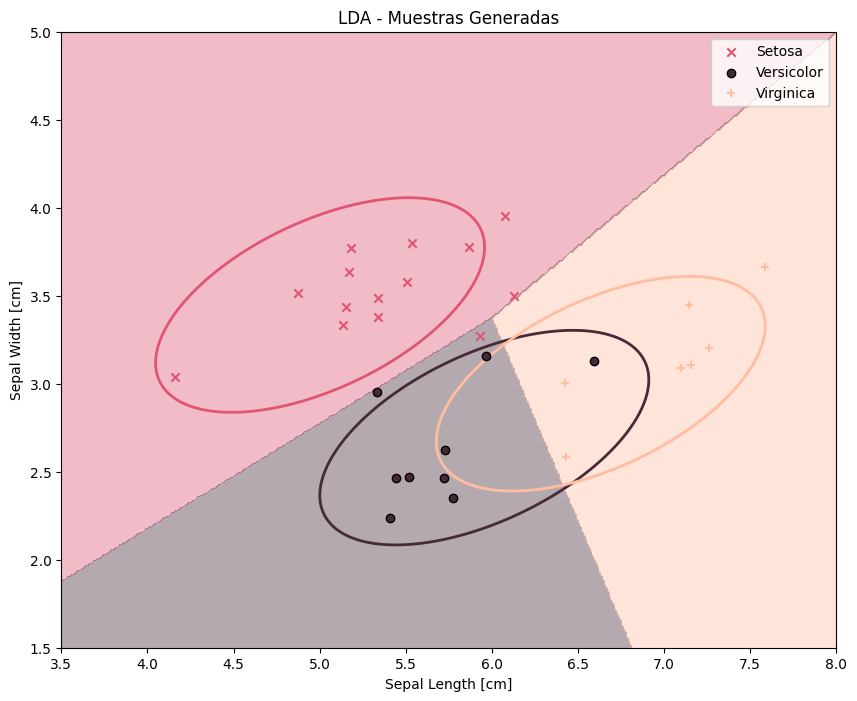

In [13]:
clases_muestras_LDA = np.random.choice([0, 1, 2], size = 30, replace = True, p = LDA_model.c_y)
muestras_LDA = np.array([np.random.multivariate_normal(LDA_model.mean[c], LDA_model.cov) for c in clases_muestras_LDA])

data_0_muestras_LDA = pd.DataFrame(muestras_LDA[clases_muestras_LDA == 0], columns=['sepal length (cm)', 'sepal width (cm)'])
data_1_muestras_LDA = pd.DataFrame(muestras_LDA[clases_muestras_LDA == 1], columns=['sepal length (cm)', 'sepal width (cm)'])
data_2_muestras_LDA = pd.DataFrame(muestras_LDA[clases_muestras_LDA == 2], columns=['sepal length (cm)', 'sepal width (cm)'])

plt.figure(figsize = (10, 8))
for i in range(LDA_model.n_clases):
    gaussian = sp.stats.multivariate_normal(mean = LDA_model.mean[i], cov = LDA_model.cov)
    pdf_gaussian = gaussian.pdf(grid).reshape(XX.shape)
    plt.contour(XX, YY, pdf_gaussian, levels = [0.2], colors = colores[i], linewidths = 2)

Z = LDA_model.predict(grid).reshape(XX.shape)
plt.contourf(XX, YY, Z, levels = [-0.5, 0.5, 1.5, 2.5], colors = colores, alpha = 0.4, linestyles = 'solid')

scatter_dataset(data_0_muestras_LDA, data_1_muestras_LDA, data_2_muestras_LDA, 'LDA - Muestras Generadas', colores)
plt.show()

---

#### (D) *Discriminante cuadrático:*

**Repetir los incisos (B) y (C) utilizando un algoritmo QDA.**

&ensp; A partir de lo ya trabajado con *LDA*, este apartado sigue una estructura similar, pero introduce una diferencia clave en el modelado probabilístico. Mientras que el modelo lineal asumía una covarianza común para todas las clases, el algoritmo *QDA* permite que cada clase tenga su propia matriz de covarianza.

&ensp; Así, la variable $Y$ sigue siendo categórica como se definió previamente, pero la distribución condicional de $X$ dado $Y = k$ cambia de la siguiente manera:

$$ Y \sim Cat \left( \{ c_1, \dots , c_k \} \right), ~~~~ X | Y = k \sim N \left( \mu_k , ~ \Sigma_k \right).$$

Como consecuencia, ya no se cancela el término cuadrático en la expresión de la densidad, ya que la matriz de covarianza $\Sigma_k$ varía con la clase. Específicamente, el término cuadrático:

$$ -\frac{1}{2} X^T ~ \Sigma^{-1} ~ X,$$

no puede ser eliminado como en *LDA*, porque $\Sigma_k$ ya no es constante entre clases. Por lo tanto, los exponentes de la función discriminante toman la siguiente forma:

$$ -\frac{1}{2} (X - \mu_k)^T ~ \Sigma^{-1} ~ (X - \mu_k) + \log (c_k) - \frac{\log \left| \Sigma_k \right|}{2}.$$

&ensp; Un punto a destacar es que en el código se asigna `b` a los terminos logarítmicos. Esto no es una convención global, simplemente se trata de utilizar una variable de la clase que en *QDA* no iba a ser utilizada para mejorar la legibilidad del código.

&ensp; Una vez realizadas las aclaraciones teóricas, se procede a explicar lo desarrollado a nivel código, que es análogo a lo ya desarrollado en el apartado de *LDA*. Por ende, en este primer inciso, se inicializa el modelo *QDA* utilizando la clase descrita con antelación y se grafican las regiones de decisión, que ahora son parábolas (por el término cuadrático), con las curvas de nivel de cada gaussiana considerando las medias y covarianzas correspondientes a cada clase.

In [14]:
QDA_model = Discriminant_Analysis(model = 'QDA')
QDA_model.fit(X_train, Y_train)

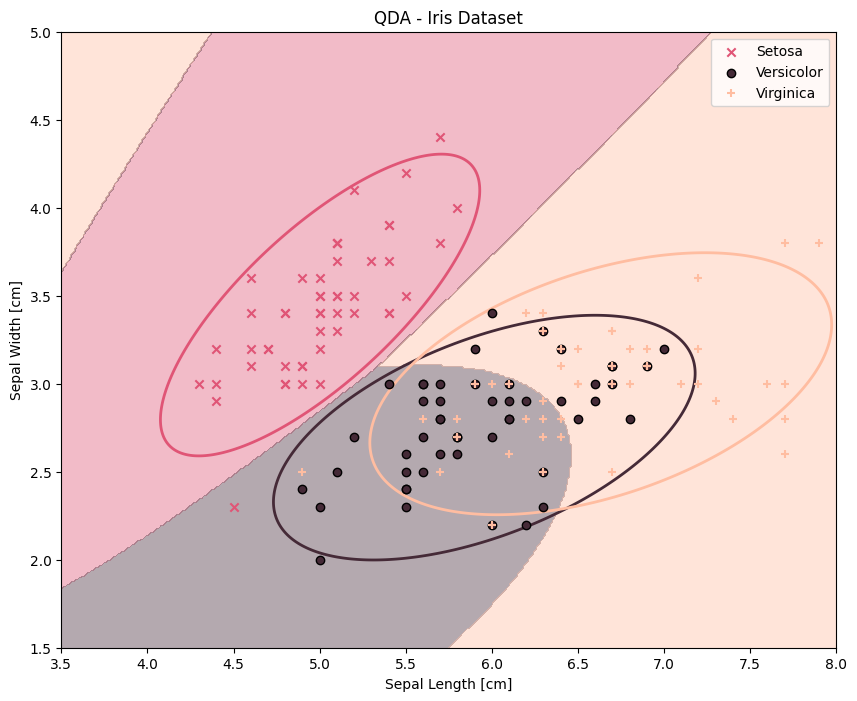

In [15]:
plt.figure(figsize = (10, 8))
for i in range(QDA_model.n_clases):
    gaussian = sp.stats.multivariate_normal(mean = QDA_model.mean[i], cov = QDA_model.covs[i])
    pdf_gaussian = gaussian.pdf(grid).reshape(XX.shape)
    plt.contour(XX, YY, pdf_gaussian, levels = [0.08], colors = colores[i], linewidths = 2)

Z = QDA_model.predict(grid).reshape(XX.shape)
plt.contourf(XX, YY, Z, levels = [-0.5, 0.5, 1.5, 2.5], colors = colores, alpha = 0.4, linestyles = 'solid')

scatter_dataset(data_0, data_1, data_2, 'QDA - Iris Dataset', colores)
plt.show()

&ensp; Luego, se vuelve a utilizar la función $\texttt{accuracy}$.

In [16]:
accuracy_testeo_QDA = accuracy(X_test, Y_test, QDA_model)
display(f'Accuracy Testeo modelo QDA: {accuracy_testeo_QDA:.2f}')

accuracy_train_QDA = accuracy(X_train, Y_train, QDA_model)
display(f'Accuracy Train modelo QDA: {accuracy_train_QDA:.2f}')

'Accuracy Testeo modelo QDA: 0.71'

'Accuracy Train modelo QDA: 0.80'

&ensp; Por último, se generan las muestras sintéticas del modelo de igual manera que en para el *LDA*.

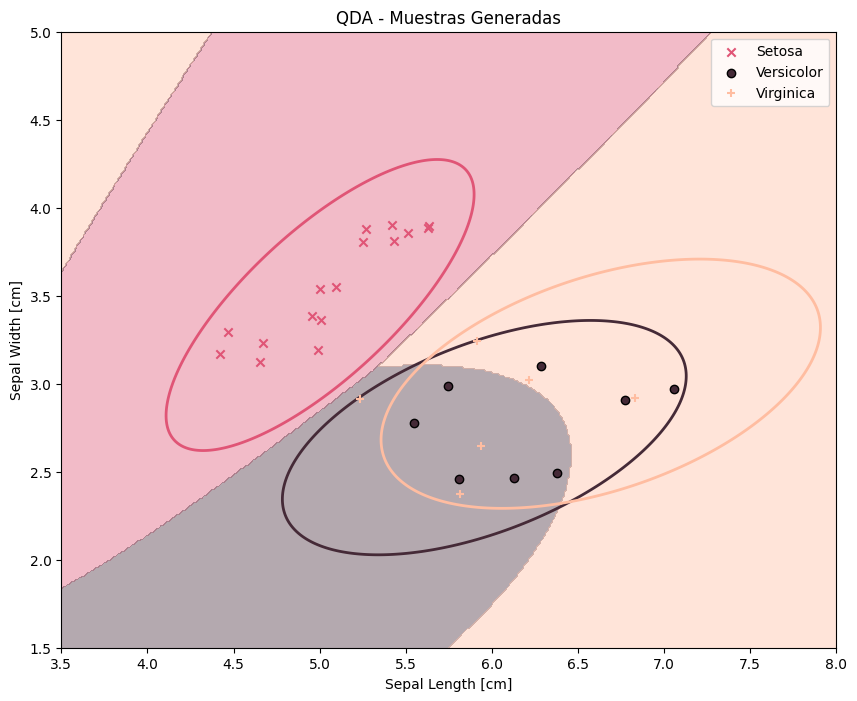

In [17]:
clases_muestras_QDA = np.random.choice([0, 1, 2], size = 30, replace = True, p = QDA_model.c_y)
muestras_QDA = np.array([np.random.multivariate_normal(QDA_model.mean[c], QDA_model.covs[c]) for c in clases_muestras_QDA])

data_0_muestras_QDA = pd.DataFrame(muestras_QDA[clases_muestras_QDA == 0], columns=['sepal length (cm)', 'sepal width (cm)'])
data_1_muestras_QDA = pd.DataFrame(muestras_QDA[clases_muestras_QDA == 1], columns=['sepal length (cm)', 'sepal width (cm)'])
data_2_muestras_QDA = pd.DataFrame(muestras_QDA[clases_muestras_QDA == 2], columns=['sepal length (cm)', 'sepal width (cm)'])

plt.figure(figsize = (10, 8))
for i in range(QDA_model.n_clases):
    gaussian = sp.stats.multivariate_normal(mean = QDA_model.mean[i], cov = QDA_model.covs[i])
    pdf_gaussian = gaussian.pdf(grid).reshape(XX.shape)
    plt.contour(XX, YY, pdf_gaussian, levels = [0.1], colors = colores[i], linewidths = 2)

Z = QDA_model.predict(grid).reshape(XX.shape)
plt.contourf(XX, YY, Z, levels = [-0.5, 0.5, 1.5, 2.5], colors = colores, alpha = 0.4, linestyles = 'solid')

scatter_dataset(data_0_muestras_QDA, data_1_muestras_QDA, data_2_muestras_QDA, 'QDA - Muestras Generadas', colores)
plt.show()

---

#### (E) *K vecinos más cercanos:*

**Repetir el inciso (B) utilizando un algoritmo KNN con K = 6 (excepto por las curvas de nivel asociadas a las medias y covarianzas que aquí no corresponden).**

&ensp; Por último, en este inciso se implementa el algoritmo *k Nearest Neighbors (kNN)*. Se trata de un modelo no paramétrico, lo que significa que no asume ninguna estructura previa para la distribución de los datos. A diferencia de los modelos vistos anteriormente, *kNN* no realiza un aprendizaje explícito durante el entrenamiento, sino que simplemente almacena los datos y toma decisiones en el momento de la predicción.

&ensp; Para clasificar un nuevo punto, el algoritmo realiza los siguientes pasos:

1. Calcula la distancia entre el punto nuevo y todos los puntos del conjunto de entrenamiento.

2. Selecciona los *k vecinos más cercanos*.

3. Si se realiza una predicción *hard*, asigna al nuevo punto la clase más frecuente entre esos vecinos. En cambio, en la predicción *soft*, estima la probabilidad de pertenencia a cada clase según la proporción de vecinos de cada clase.

&ensp; De esta manera, el código define una clase `KNN` que implementa el algoritmo descrito, con tres métodos:

- `__init__:` Constructor de la clase, recibe el número de vecinos a considerar `k` e inicializa atributos para guardar los datos de entrenamiento y el número de clases.

- `fit:` Simplemente almacena los datos de entrenamiento $X$ y sus etiquetas $y$. También calcula el número de clases distintas presentes en $y$.

- `predict_proba:` Implementa la predicción *soft*, según lo especificado anteriormente. Devuelve una matriz donde cada fila representa la distribución de probabilidad del punto correspondiente.

- `predict:` Implementa la predicción *hard*, utilizando `predict_proba` para obtener las probabilidades y asignando a cada punto la clase con mayor probabilidad.


In [18]:
class KNN:

    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, k):
        self.k = k
        self.n_clases = None
        self.X_train = None
        self.Y_train = None

    # Etapa de entrenamiento
    def fit(self, X, y):
        self.X_train = X
        self.Y_train = y
        self.n_clases = len(np.unique(y))

    # Etapa de testeo soft
    def predict_proba(self, X):
        matriz_probas = np.zeros((X.shape[0], self.n_clases))
        for i, x in enumerate(X):
            distance = np.linalg.norm(self.X_train - x, axis = 1)
            knn = np.argsort(distance)[:self.k]
            knn_classes = self.Y_train[knn]
            contador_clases = np.bincount(knn_classes, minlength=self.n_clases)
            proba = np.zeros(self.n_clases)
            for j in range(self.n_clases):
                proba[j] = contador_clases[j] / self.k
            matriz_probas[i] = proba
        return matriz_probas

    # Etapa de testeo hard
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis = 1)


&ensp; Finalmente, se inicializa la clase, se la entrena y se grafican las regiones de decisión con el *dataset* del Iris.

In [19]:
KNN_model = KNN(k = 6)
KNN_model.fit(X_train, Y_train)

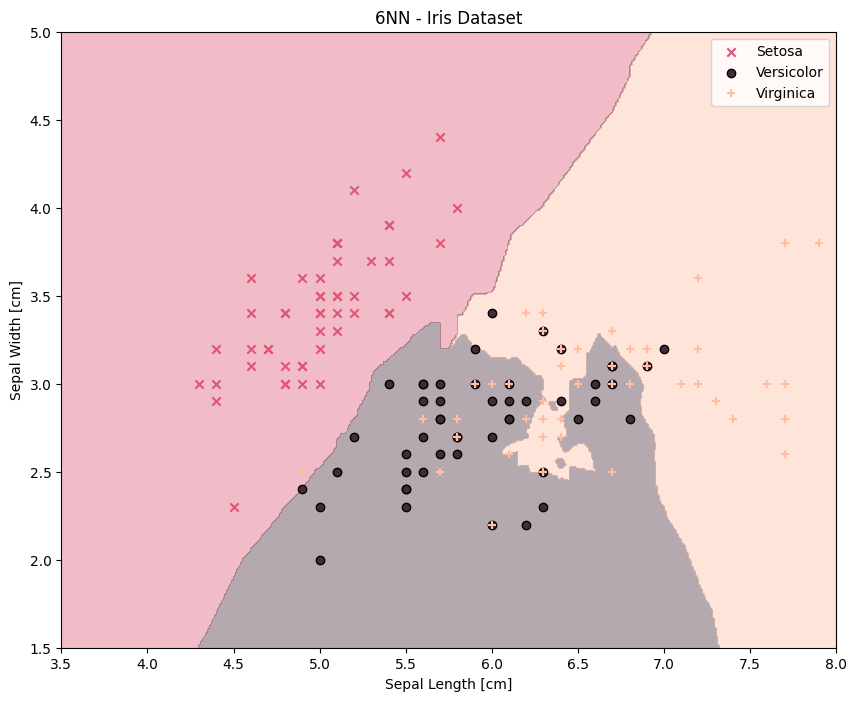

In [20]:
plt.figure(figsize = (10, 8))

Z = KNN_model.predict(grid.reshape(-1, 2))
plt.contourf(XX, YY, Z.reshape(XX.shape), levels = [-0.5, 0.5, 1.5, 2.5], colors = colores, alpha = 0.4, linestyles = 'solid')

scatter_dataset(data_0, data_1, data_2, '6NN - Iris Dataset', colores)

plt.xlabel('Sepal Length [cm]')
plt.ylabel('Sepal Width [cm]')
plt.title('6NN - Iris Dataset')
plt.legend()
plt.xlim(3.5, 8)
plt.ylim(1.5, 5)
plt.show()

In [21]:
accuracy_testeo_KNN = accuracy(X_test, Y_test, KNN_model)
display(f'Accuracy Testeo modelo KNN: {accuracy_testeo_KNN:.2f}')
accuracy_train_KNN = accuracy(X_train, Y_train, KNN_model)
display(f'Accuracy Train modelo KNN: {accuracy_train_KNN:.2f}')

'Accuracy Testeo modelo KNN: 0.73'

'Accuracy Train modelo KNN: 0.86'

---
---

### <center> Conclusiones

&ensp; A lo largo del trabajo se implementaron y analizaron distintos enfoques de clasificación supervisada aplicados al dataset Iris. El objetivo fue comparar modelos con distinto fundamentos teóricos, tanto probabilísticos como no paramétricos, para evaluar su comportamiento sobre un problema representativo. La experiencia de programar los algoritmos desde cero permitió reforzar los conceptos teóricos y visualizar cómo distintas hipótesis sobre los datos impactan en la forma en que cada modelo toma decisiones.

&ensp; Por un lado, una diferencia clave entre los modelos *LDA* y *QDA* se evidenció al graficar las curvas de nivel y las regiones de decisión. En el caso del *LDA*, como se asume una misma matriz de covarianza para todas las clases, las curvas de nivel de las distribuciones gaussianas tienen igual pendiente. Además, al ser un modelo lineal, se generan regiones de decisión delimitadas por rectas. Por el contrario, en el modelo cuadrático, cada clase posee su propia matriz de covarianza, lo que permite que las curvas de nivel presenten pendientes distintas. Al tener distintas covarianzas, el término cuadrático no se cancela, lo que genera fronteras de decisión cuadráticas, que típicamente adoptan la forma de parábolas, adaptándose mejor a distribuciones no lineales.

&ensp; Por otro lado, una vez entrenados los modelos y evaluados sobre el conjunto de testeo, se observó que todos los clasificadores alcanzan valores de *accuracy* similares, incluyendo al algoritmo k-NN, a pesar de ser un modelo no paramétrico. Esto indica que, para este conjunto de datos en particular, incluso métodos sin una modelización explícita de la distribución pueden ser efectivos.

&ensp; En resumen, el trabajo permitió comparar modelos desde su construcción hasta su interpretación geométrica y su desempeño práctico, ofreciendo una visión integral del problema de clasificación en el contexto de aprendizaje supervisado.